# Imports

In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from matplotlib import pyplot as plt

In [2]:
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as T
from torchvision import models
import albumentations as A

import timm
import librosa

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import GroupKFold

import gc

def clear_memory():
    torch.cuda.empty_cache()
    gc.collect()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Spectrogram PART

In [3]:
OUTPUT_PATH = "/kaggle/working"

TRAIN_CSV = "/kaggle/input/hms-harmful-brain-activity-classification/train.csv"
TEST_CSV = "/kaggle/input/hms-harmful-brain-activity-classification/test.csv"

GROUPED_CSV = "/kaggle/input/grouped-train-csv/grouped_train.csv"
TRAIN_SPECTROGRAMS = "/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms"
TEST_SPECTROGRAMS = "/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms"

TRAIN_EEGS = "/kaggle/input/hms-harmful-brain-activity-classification/train_eegs"
TEST_EEGS = "/kaggle/input/hms-harmful-brain-activity-classification/test_eegs"

FULL_SPECTROGRAMS = "/kaggle/input/brain-spectrograms/specs.npy"
FULL_EEGS = "/kaggle/input/custom-eegs/eeg_specs.npy"
LABELS = ["seizure_vote", "lpd_vote", "gpd_vote", "lrda_vote", "grda_vote", "other_vote"]

BATCH_SIZE = 32
GROUP_FOLDS = 5

In [4]:
# eegs data preprocessing
USE_WAVELET = None 

NAMES = ["LL", "RL", "LP", "RP"]

FEATS = [["Fp1","F7","T3","T5","O1"],
         ["Fp2","F8","T4","T6","O2"],
         ["Fp1","F3","C3","P3","O1"],
         ["Fp2","F4","C4","P4","O2"]]

def maddest(d, axis: int = None):
    """
    Denoise function.
    """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise(x: np.ndarray, wavelet: str = 'haar', level: int = 1): 
    coeff = pywt.wavedec(x, wavelet, mode="per") # multilevel 1D Discrete Wavelet Transform of data.
    sigma = (1/0.6745) * maddest(coeff[-level])
    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    output = pywt.waverec(coeff, wavelet, mode='per')
    return output

def spectrogram_from_eeg(parquet_path):
    # LOAD MIDDLE 50 SECONDS OF EEG SERIES
    eeg = pd.read_parquet(parquet_path)
    middle = (len(eeg)-10_000)//2
    eeg = eeg.iloc[middle:middle+10_000]
    
    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((128,256,4),dtype='float32')
    
    signals = []
    for k in range(4):
        COLS = FEATS[k]
        
        for kk in range(4):
        
            # COMPUTE PAIR DIFFERENCES
            x = eeg[COLS[kk]].values - eeg[COLS[kk+1]].values

            # FILL NANS
            m = np.nanmean(x)
            if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
            else: x[:] = 0

            # DENOISE
            if USE_WAVELET:
                x = denoise(x, wavelet=USE_WAVELET)
            signals.append(x)

            # RAW SPECTROGRAM
            mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//256, 
                  n_fft=1024, n_mels=128, fmin=0, fmax=20, win_length=128)

            # LOG TRANSFORM
            width = (mel_spec.shape[1]//32)*32
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]

            # STANDARDIZE TO -1 TO 1
            mel_spec_db = (mel_spec_db+40)/40 
            img[:,:,k] += mel_spec_db
                
        # AVERAGE THE 4 MONTAGE DIFFERENCES
        img[:,:,k] /= 4.0
        
    return img

In [5]:
# store test eegs into dictionary
full_eegs = {}
for file in os.listdir(TEST_EEGS):
    temp = pd.read_parquet(os.path.join(TEST_EEGS, file))
    specs_id = file.split(".")[0]
    full_eegs[int(specs_id)] = spectrogram_from_eeg(os.path.join(TEST_EEGS, file))
    del temp, specs_id

print(len(full_eegs))

1


In [6]:
# spectrograms data preprocessing
test_df = pd.read_csv(TEST_CSV)

full_specs = {}
for file in os.listdir(TEST_SPECTROGRAMS):
    temp = pd.read_parquet(os.path.join(TEST_SPECTROGRAMS, file))
    specs_id = file.split(".")[0]
    full_specs[int(specs_id)] = temp.iloc[:, 1:].values
    del temp, specs_id
    
print(len(full_specs))

1


In [7]:
# Build CustomDataset
class CustomDataset(Dataset):
    def __init__(self, metadata, specs_dict, eegs_dict, transforms=False, mode="Train"):
        self.metadata = metadata
        self.specs_dict = specs_dict
        self.eegs_dict = eegs_dict
        self.transforms = transforms
        self.mode = mode
        self.__epsilon = 1e-6

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, index):
        X, y = self.__create_data(index)
        
        if self.transforms:
            X = self.__data_transformation(X)

        # convert to tensors
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        return X, y

    def __create_data(self, index):
        X = np.zeros((128, 256, 8), dtype=np.float32)
        y = np.zeros((6), dtype=np.float32)
        img = np.ones((128, 256), dtype=np.float32)
        row = self.metadata.iloc[index]

        if self.mode == "Train":
            offset = int((row["min"] + row["max"])//4)
            # convert labels to float32
            y = row[LABELS].values.astype(np.float32)

        else:
            offset = 0

        for i in range(4):
            # 100x300xi
            img = self.specs_dict[row["spectrogram_id"]][offset:offset+300, i*100:(i+1)*100].T

            # log transform
            img = np.clip(img, np.exp(-4), np.exp(8))
            img = np.log(img)

            # standardization
            m = np.nanmean(img.flatten())
            std = np.nanstd(img.flatten())
            img = (img - m) / (std + self.__epsilon)
            img = np.nan_to_num(img, 0.0)

            # fit into X (0-3 at dim=3)
            # 100x256xi
            X[14: -14, :, i] = img[:, 22:-22] / 2.0 # ????????

        # eegs
        # 128x256x4
        img = self.eegs_dict[row["eeg_id"]]
        X[:, :, 4:] = img

        return X, y


    def __data_transformation(self, x):
        transforms = A.Compose([A.HorizontalFlip(p=0.5)])
        return transforms(image=x)["image"]

In [8]:
# Build DataLoader and test
test_dataset = CustomDataset(test_df, full_specs, full_eegs, mode="Test")
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

x, y = test_dataset[0]
print("x shape:", x.shape)
print("y shape:", y.shape)

x shape: torch.Size([128, 256, 8])
y shape: torch.Size([6])


**Model 1: N x 12 x 256 x 256**

In [9]:
class Effnet_256(nn.Module):
    def __init__(self, num_classes=6, pretrained=True):
        super().__init__()
        self.model = models.efficientnet_b0(pretrained=pretrained)
        self.model.features[0][0] = nn.Conv2d(12, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        num_features = self.model.classifier[1].in_features
        self.model.classifier = torch.nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.__reshape_input(x)
        x = self.model(x)
        return x

    def __reshape_input(self, x):
        """
        (N, 128, 256, 8) -> (N, 256, 256, 12])
        """
        # LL + RL 256 x 256
        spectrograms_1 = [x[:, :, :, i:i+1] for i in range(2)]
        spectrograms_1 = torch.cat(spectrograms_1, dim=1)

        # LP + RP 256 x 256
        spectrograms_2 = [x[:, :, :, i:i+1] for i in range(2, 4)]
        spectrograms_2 = torch.cat(spectrograms_2, dim=1)

        # LL + LP 256 x 256
        eegs_1 = [x[:, :, :, i:i+1] for i in range(4, 6)]
        eegs_1 = torch.cat(eegs_1, dim=1)

        # LP + RP 256 x 256
        eegs_2 = [x[:, :, :, i:i+1] for i in range(6, 8)]
        eegs_2 = torch.cat(eegs_2, dim=1)

        # stack
        x = torch.cat([spectrograms_1, spectrograms_2, eegs_1, eegs_2], dim=3)
        x = torch.cat([x, x, x], dim=3)

        # permute
        x = x.permute(0, 3, 1, 2)
        return x

In [10]:
# Inference
def inference(test_loader, model, device):
    model.eval()
    predictions_dict = {}
    predictions = []
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            prediction = model(x)
            prediction = F.softmax(prediction)
            predictions.append(prediction.to("cpu").numpy())
            
    predictions_dict["predictions"] = np.concatenate(predictions)
    return predictions_dict

In [11]:
# Load pretrained model
model_list = os.listdir("/kaggle/input/efficientnet-b0-256")

model1_output = []

for model_name in model_list:
    test_dataset = CustomDataset(test_df, full_specs, full_eegs, transforms=False, mode="Test")
    train_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Effnet_256(num_classes=6, pretrained=False)
    checkpoint = torch.load(os.path.join("/kaggle/input/efficientnet-b0-256", model_name), map_location="cpu")
    model.load_state_dict(checkpoint["model"])
    model.to(device)
    predictions_dict = inference(test_loader, model, device)
    model1_output.append(predictions_dict["predictions"])
    clear_memory()
    
model1_output = np.array(model1_output)
model1_output = np.mean(model1_output, axis=0)
print(model1_output)

[[1.3819794e-01 2.8095702e-02 1.9582195e-04 1.8614370e-01 2.9172828e-02
  6.1819398e-01]]


Model 2: N x 3 x 512 x 512

In [12]:
class Effnet_512(nn.Module):
    def __init__(self, num_classes=6, pretrained=True):
        super().__init__()
        self.model = models.efficientnet_b0(pretrained=pretrained)
        num_features = self.model.classifier[1].in_features
        self.model.classifier = torch.nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.__reshape_input(x)
        x = self.model(x)
        return x

    def __reshape_input(self, x):
        """
        reshape input from (N, 128, 256, 8) to (N, 512, 512, 3) and permute to (N, 3, 512, 512)
        """
        spectrograms = [x[:, :, :, i:i+1] for i in range(4)]
        spectrograms = torch.cat(spectrograms, dim=1)
        eegs = [x[:, :, :, i:i+1] for i in range(4, 8)]
        eegs = torch.cat(eegs, dim=1)
        # now spectrograms and eegs are both Nx512x256x1
        x = torch.cat([spectrograms, eegs], dim=2)
        x = torch.cat([x, x, x], dim=3)
        x = x.permute(0, 3, 1, 2)
        return x

In [13]:
model_list = os.listdir("/kaggle/input/efficientnet-b0-512")
# model_list = os.listdir("/kaggle/input/efficientnet-512-epoch50")

model2_output = []

for model_name in model_list:
    test_dataset = CustomDataset(test_df, full_specs, full_eegs, transforms=False, mode="Test")
    train_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Effnet_512(num_classes=6, pretrained=False)
    checkpoint = torch.load(os.path.join("/kaggle/input/efficientnet-b0-512", model_name), map_location="cpu")
#     checkpoint = torch.load(os.path.join("/kaggle/input/efficientnet-512-epoch50", model_name), map_location="cpu")
    model.load_state_dict(checkpoint["model"])
    model.to(device)
    predictions_dict = inference(test_loader, model, device)
    model2_output.append(predictions_dict["predictions"])
    clear_memory()
    
model2_output = np.array(model2_output)
model2_output = np.mean(model2_output, axis=0)
print(model2_output)

[[0.24003184 0.07617775 0.00060206 0.29084778 0.05024021 0.34210038]]


# Model 3: two stages 512

In [14]:
# two stages
MODEL_NAME = "efficientnet_b2"

class Effnet_b2(nn.Module):
    def __init__(self, num_classes=6, pretrained=True):
        super().__init__()
        self.model = models.efficientnet_b2(pretrained=pretrained)
        num_features = self.model.classifier[1].in_features
        self.model.classifier = torch.nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.__reshape_input(x)
        x = self.model(x)
        return x

    def __reshape_input(self, x):
        """
        reshape input from (N, 128, 256, 8) to (N, 512, 512, 3) and permute to (N, 3, 512, 512)
        """
        spectrograms = [x[:, :, :, i:i+1] for i in range(4)]
        spectrograms = torch.cat(spectrograms, dim=1)
        eegs = [x[:, :, :, i:i+1] for i in range(4, 8)]
        eegs = torch.cat(eegs, dim=1)
        # now spectrograms and eegs are both Nx512x256x1
        x = torch.cat([spectrograms, eegs], dim=2)
        x = torch.cat([x, x, x], dim=3)
        x = x.permute(0, 3, 1, 2)
        return x

model_list = os.listdir("/kaggle/input/b2-two-stages")

model3_output = []

# use filtered model
for model_name in model_list:
    test_dataset = CustomDataset(test_df, full_specs, full_eegs, transforms=False, mode="Test")
    train_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Effnet_b2(num_classes=6, pretrained=False)
    checkpoint = torch.load(os.path.join("/kaggle/input/b2-two-stages", model_name), map_location="cpu")
    model.load_state_dict(checkpoint["model"])
    model.to(device)
    predictions_dict = inference(test_loader, model, device)
    model3_output.append(predictions_dict["predictions"])
    clear_memory()
    
model3_output = np.array(model3_output)
model3_output = np.mean(model3_output, axis=0)
print(model3_output)

[[0.14804468 0.08879526 0.00113507 0.21691449 0.02654848 0.518562  ]]


In [15]:
spectrogram_output = np.mean([model1_output, model2_output, model3_output], axis=0)

In [16]:
# # submission
# submission_df = test_df[["eeg_id"]].copy()
# submission_df[LABELS] = output
# submission_df.to_csv("submission.csv", index=False)
# print(submission_df.shape)
# submission_df

# EEG PART

In [17]:
train = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
votes = train.columns[-6:]

In [18]:
features = ['Fp1', 'T3', 'C3', 'O1', 'Fp2', 'C4', 'T4', 'O2']
features_to_index = {x: y for x, y in zip(features, range(len(features)))}

In [19]:
def eeg_from_parquet(parquet_path, display=False):
    # select the middle 50 seconds
    eeg = pd.read_parquet(parquet_path, columns=features)
    rows = len(eeg)
    offset = (rows-10_000) // 2
    eeg = eeg.iloc[offset:offset+10_000]  # middle 50 seconds, has the same amount of readings to left and right

    if display:
        plt.figure(figsize=(10, 5))
        offset = 0

    # convert to numpy
    data = np.zeros((10_000, len(features)))  # create placeholder of same shape with zeros
    for index, feature in enumerate(features):

        # fill NaN
        x = eeg[feature].values.astype('float32')  # convert to float32
        mean = np.nanmean(x)  # arithmetic mean along the specified axis, ignoring NaNs
        nan_percentage = np.isnan(x).mean()  # percentage of NaN values in feature
        if nan_percentage < 1:  # if some values are nan, but not all
            x = np.nan_to_num(x, nan=mean)
        else:
          # if all values are nan
          x[:] = 0

        data[:, index] = x

        if display:
            if index != 0:
                offset += x.max()
            plt.plot(range(10_000), x-offset, label=feature)
            offset -= x.min()

    if display:
        # plt.legend()
        name = parquet_path.split('/')[-1].split('.')[0]
        plt.yticks([])
        plt.title(f'EEG {name}',size=16)
        plt.axis('off')
        plt.show()

    return data

**Butter Low-Pass Filter**

In [20]:
from scipy.signal import butter, lfilter

def butter_lowpass_filter(data, cutoff_freq=20, sampling_rate=200, order=4):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = lfilter(b, a, data, axis=0)
    return filtered_data

**Data Loader with Butter Low-Pass Filter**

In [21]:
import tensorflow as tf

class DataGenerator(tf.keras.utils.Sequence):
    # generate data for Keras
    def __init__(self, data, batch_size=32, shuffle=False, eegs=None, mode='train', downsample=5, tag=None):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.eegs = eegs
        self.mode = mode
        self.downsample = downsample
        self.tag = tag
        self.on_epoch_end()

    def __len__(self):
        # denote the number of batches per epoch
        ct = int( np.ceil( len(self.data) / self.batch_size ) )
        return ct

    def __getitem__(self, index):
        # generate one batch of data
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]  # [0:32] -> [32:64] ...
        x, y = self.__data_generation(indexes)
        x, y = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
        if self.tag:
            return x[:,::self.downsample,:], y
        return x[:,::self.downsample,:].transpose(1, 2), y

    def on_epoch_end(self):
        # update indexes after each epoch
        self.indexes = np.arange( len(self.data) )
        if self.shuffle: np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        # generate data containing batch_size samples
        x = np.zeros((len(indexes), 10_000, 8), dtype='float32')
        y = np.zeros((len(indexes), 6), dtype='float32')

        sample = np.zeros((10_000, x.shape[-1]))
        for j, i in enumerate(indexes):
            row = self.data.iloc[i]
            data = self.eegs[row.eeg_id]

            # convert EEG signals to montaged EEG signals
            sample[:, 0] = data[:, features_to_index['Fp1']] - data[:, features_to_index['T3']]
            sample[:, 1] = data[:, features_to_index['T3']] - data[:, features_to_index['O1']]

            sample[:, 2] = data[:, features_to_index['Fp1']] - data[:, features_to_index['C3']]
            sample[: ,3] = data[:, features_to_index['C3']] - data[:, features_to_index['O1']]

            sample[:, 4] = data[:, features_to_index['Fp2']] - data[:, features_to_index['C4']]
            sample[:, 5] = data[:, features_to_index['C4']] - data[:, features_to_index['O2']]

            sample[:, 6] = data[:, features_to_index['Fp2']] - data[:, features_to_index['T4']]
            sample[:, 7] = data[:, features_to_index['T4']] - data[:, features_to_index['O2']]

            # standardization
            sample = np.clip(sample, -1024, 1024)
            sample = np.nan_to_num(sample, nan=0) / 32.0

            # apply Butter low-pass filter
            sample = butter_lowpass_filter(sample)

            x[j,] = sample
            if self.mode != 'test':
                y[j] = row[votes]

        return x, y

2024-04-01 06:37:15.549234: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 06:37:15.549328: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 06:37:15.668429: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Build WaveModel**

In [22]:
from tensorflow.keras.layers import Input, Dense, Multiply, Add, Conv1D, Concatenate

def wave_block(x, filters, kernel_size, n):
    dilation_rates = [2**i for i in range(n)]
    x = Conv1D(filters = filters,
               kernel_size = 1,
               padding = 'same')(x)
    res_x = x
    for dilation_rate in dilation_rates:
        tanh_out = Conv1D(filters = filters,
                          kernel_size = kernel_size,
                          padding = 'same', 
                          activation = 'tanh', 
                          dilation_rate = dilation_rate)(x)
        sigm_out = Conv1D(filters = filters,
                          kernel_size = kernel_size,
                          padding = 'same',
                          activation = 'sigmoid', 
                          dilation_rate = dilation_rate)(x)
        x = Multiply()([tanh_out, sigm_out])
        x = Conv1D(filters = filters,
                   kernel_size = 1,
                   padding = 'same')(x)
        res_x = Add()([res_x, x])
    return res_x

In [23]:
def build_model():
        
    # INPUT 
    inp = tf.keras.Input(shape=(2_000,8))
    
    ############
    # FEATURE EXTRACTION SUB MODEL
    inp2 = tf.keras.Input(shape=(2_000,1))
    x = wave_block(inp2, 8, 3, 12)
    x = wave_block(x, 16, 3, 8)
    x = wave_block(x, 32, 3, 4)
    x = wave_block(x, 64, 3, 1)
    model2 = tf.keras.Model(inputs=inp2, outputs=x)
    ###########
    
    # LEFT TEMPORAL CHAIN
    x1 = model2(inp[:,:,0:1])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,1:2])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z1 = tf.keras.layers.Average()([x1,x2])
    
    # LEFT PARASAGITTAL CHAIN
    x1 = model2(inp[:,:,2:3])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,3:4])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z2 = tf.keras.layers.Average()([x1,x2])
    
    # RIGHT PARASAGITTAL CHAIN
    x1 = model2(inp[:,:,4:5])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,5:6])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z3 = tf.keras.layers.Average()([x1,x2])
    
    # RIGHT TEMPORAL CHAIN
    x1 = model2(inp[:,:,6:7])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,7:8])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z4 = tf.keras.layers.Average()([x1,x2])
    
    # COMBINE CHAINS
    y = tf.keras.layers.Concatenate()([z1,z2,z3,z4])
    y = tf.keras.layers.Dense(64, activation='relu')(y)
    y = tf.keras.layers.Dense(6,activation='softmax', dtype='float32')(y)
    
    # COMPILE MODEL
    model = tf.keras.Model(inputs=inp, outputs=y)
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    loss = tf.keras.losses.KLDivergence()
    model.compile(loss=loss, optimizer = opt)
    
    return model

**ResNet Model**

In [24]:
class ResNet_1D_Block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, downsampling):
        super(ResNet_1D_Block, self).__init__()
        self.bn1 = nn.BatchNorm1d(num_features=in_channels)
        self.relu = nn.ReLU(inplace=False)
        self.dropout = nn.Dropout(p=0.0, inplace=False)
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                               stride=stride, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm1d(num_features=out_channels)
        self.conv2 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size,
                               stride=stride, padding=padding, bias=False)
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.downsampling = downsampling

    def forward(self, x):
        identity = x

        out = self.bn1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)

        out = self.maxpool(out)
        identity = self.downsampling(x)

        out += identity
        return out


class EEGNet(nn.Module):

    def __init__(self, kernels, in_channels=8, fixed_kernel_size=5, num_classes=6):
        super(EEGNet, self).__init__()
        self.kernels = kernels
        self.planes = 24
        self.parallel_conv = nn.ModuleList()
        self.in_channels = in_channels

        for i, kernel_size in enumerate(list(self.kernels)):
            sep_conv = nn.Conv1d(in_channels=in_channels, out_channels=self.planes, kernel_size=(kernel_size),
                               stride=1, padding=0, bias=False,)
            self.parallel_conv.append(sep_conv)

        self.bn1 = nn.BatchNorm1d(num_features=self.planes)
        self.relu = nn.ReLU(inplace=False)
        self.conv1 = nn.Conv1d(in_channels=self.planes, out_channels=self.planes, kernel_size=fixed_kernel_size,
                               stride=2, padding=2, bias=False)
        self.block = self._make_resnet_layer(kernel_size=fixed_kernel_size, stride=1, padding=fixed_kernel_size//2)
        self.bn2 = nn.BatchNorm1d(num_features=self.planes)
        self.avgpool = nn.AvgPool1d(kernel_size=6, stride=6, padding=2)
        self.rnn = nn.GRU(input_size=self.in_channels, hidden_size=128, num_layers=1, bidirectional=True)
        self.fc = nn.Linear(in_features=280, out_features=num_classes)
        self.rnn1 = nn.GRU(input_size=156, hidden_size=156, num_layers=1, bidirectional=True)

    def _make_resnet_layer(self, kernel_size, stride, blocks=9, padding=0):
        layers = []
        downsample = None
        base_width = self.planes

        for i in range(blocks):
            downsampling = nn.Sequential(
                    nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
                )
            layers.append(ResNet_1D_Block(in_channels=self.planes, out_channels=self.planes, kernel_size=kernel_size,
                                       stride=stride, padding=padding, downsampling=downsampling))

        return nn.Sequential(*layers)

    def forward(self, x):
        out_sep = []

        for i in range(len(self.kernels)):
            sep = self.parallel_conv[i](x)
            out_sep.append(sep)

        out = torch.cat(out_sep, dim=2)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv1(out)

        out = self.block(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.avgpool(out)

        out = out.reshape(out.shape[0], -1)

        rnn_out, _ = self.rnn(x.permute(0, 2, 1))
        new_rnn_h = rnn_out[:, -1, :]

        new_out = torch.cat([out, new_rnn_h], dim=1)
        result = self.fc(new_out)

        return result

**1D CNN Model**

In [25]:
class CNN1D(nn.Module):
    def __init__(self, in_channels, kernel_size=3):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size, 1, 1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size, 1, 1)
        self.conv3 = nn.Conv1d(64, 128, kernel_size, 1, 1)
        self.conv4 = nn.Conv1d(128, 128, kernel_size, 1, 1)
        self.conv5 = nn.Conv1d(128, 256, kernel_size, 1, 1)
        self.conv6 = nn.Conv1d(256, 256, kernel_size, 1, 1)
        self.conv7 = nn.Conv1d(256, 512, kernel_size, 1, 1)
        self.conv8 = nn.Conv1d(512, 512, kernel_size, 1, 1)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(128)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(256)
        self.bn6 = nn.BatchNorm1d(256)
        self.bn7 = nn.BatchNorm1d(512)
        self.bn8 = nn.BatchNorm1d(512)
        
        self.rnn = nn.GRU(input_size=in_channels, hidden_size=128, num_layers=1, bidirectional=True)
#         self.fc = nn.Linear(3840, 6)
        self.fc1 = nn.Linear(3840, 512)
        self.fc2 = nn.Linear(512, 6)

    def forward(self, x):                       
        # N x 8 x 2000
        out = self.conv1(x)
        out = self.bn1(out)
        out = nn.functional.relu(out)
        out = nn.functional.max_pool1d(out, (2))

        # N x 64 x 1000
        out = self.conv2(out)
        out = self.bn2(out)
        out = nn.functional.relu(out)
        out = nn.functional.max_pool1d(out, (2))

        # N x 64 x 500
        out = self.conv3(out)
        out = self.bn3(out)
        out = nn.functional.relu(out)
        out = nn.functional.max_pool1d(out, (2))

        # N x 128 x 250
        out = self.conv4(out)
        out = self.bn4(out)
        out = nn.functional.relu(out)
        out = nn.functional.max_pool1d(out, (2))

        # N x 128 x 125
        out = self.conv5(out)
        out = self.bn5(out)
        out = nn.functional.relu(out)
        out = nn.functional.max_pool1d(out, (2))
        
        # N x 256 x 62
        out = self.conv6(out)
        out = self.bn6(out)
        out = nn.functional.relu(out)
        out = nn.functional.max_pool1d(out, (2))
        
        # N x 256 x 31
        out = self.conv7(out)
        out = self.bn7(out)
        out = nn.functional.relu(out)
        out = nn.functional.max_pool1d(out, (2))
        
        # N x 512 x 15
        out = self.conv8(out)
        out = self.bn8(out)
        out = nn.functional.relu(out)
        out = nn.functional.max_pool1d(out, (2))
        
        # N x 512 x 7
#         out = torch.flatten(out, 1)
        out = out.reshape(out.shape[0], -1)
        
        rnn_out, _ = self.rnn(x.permute(0, 2, 1))
        new_rnn_h = rnn_out[:, -1, :]

        new_out = torch.cat([out, new_rnn_h], dim=1)
#         new_out = self.fc(new_out)
        new_out = self.fc1(new_out)
        new_out = self.fc2(new_out)
        return new_out

In [26]:
FOLDS_TO_TRAIN = 5
DOWNSAMPLE = 5

**submission**

In [27]:
test = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')
print('Test shape:',test.shape)
test.head()

Test shape: (1, 3)


,spectrogram_id,eeg_id,patient_id
0,853520,3911565283,6885


Processing Test EEG parquets...



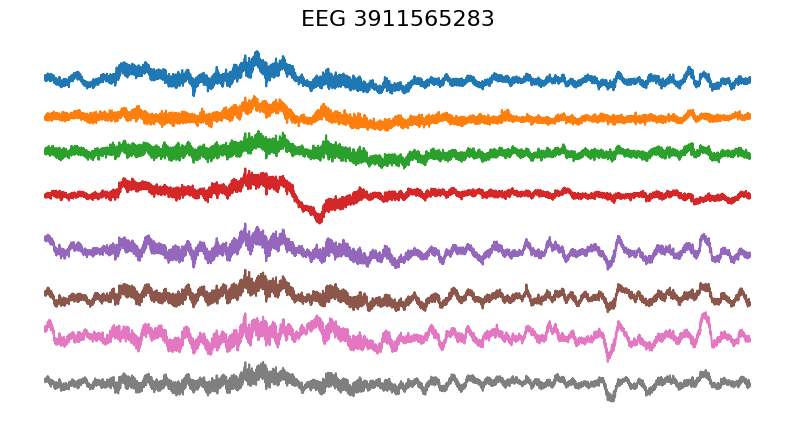

In [28]:
all_test_eegs = {}
display_num = 1
test_eeg_ids = test.eeg_id.unique()
test_eegs_parquet_folder = '/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/'

print('Processing Test EEG parquets...'); print()
for i, eeg_id in enumerate(test_eeg_ids):
    # save eeg parquet files from test_eegs into dict: {eeg_id: numpy}
    data = eeg_from_parquet(f'{test_eegs_parquet_folder}{eeg_id}.parquet', i < display_num)
    all_test_eegs[eeg_id] = data

In [29]:
wavenet_test_data = DataGenerator(test, shuffle=False, batch_size=64, eegs=all_test_eegs, mode='test', downsample=5, tag="WaveNet")
cnn_test_data = DataGenerator(test, shuffle=False, batch_size=64, eegs=all_test_eegs, mode='test', downsample=5)

In [30]:
resnet_model = EEGNet(kernels=[3, 5, 7, 9])
cnn_model = CNN1D(in_channels=8)

In [31]:
from scipy.special import softmax


cnn_all = np.zeros((len(all_test_eegs), 6))
resnet_all = np.zeros((len(all_test_eegs), 6))

wavenet_preds = []
wavenet_model = build_model()

print('Inferring test... ',end='')

for i in range(FOLDS_TO_TRAIN):
    resnet_preds = []
    cnn_preds = []
    print(f'fold {i+1}, ',end='')
    
    cnn_model.load_state_dict(torch.load(f'/kaggle/input/combine-cnn-and-resnet200-epochs/CNNmodel_{i}.pt'))
    cnn_model.eval()
    cnn_model.cpu()
    
    resnet_model.load_state_dict(torch.load(f'/kaggle/input/combine-cnn-and-resnet200-epochs/RNmodel_{i}.pt'))
    resnet_model.eval()
    resnet_model.cpu()
    
    for batch in cnn_test_data:
        cnn_pred = cnn_model(batch[0])
        cnn_preds.append(cnn_pred.detach().numpy())
        
        resnet_pred = resnet_model(batch[0])
        resnet_preds.append(resnet_pred.detach().numpy())

    cnn_preds = softmax(np.vstack(cnn_preds), axis=1)
    resnet_preds = softmax(np.vstack(resnet_preds), axis=1)
    
    cnn_all += cnn_preds
    resnet_all += resnet_preds
    
    wavenet_model.load_weights(f'/kaggle/input/hms-wavenet-weights50-epochs/WaveNet_fold{i}.weights.h5')
    wavenet_pred = wavenet_model.predict(wavenet_test_data, verbose=0)
    wavenet_preds.append(wavenet_pred)

cnn_preds = cnn_all / FOLDS_TO_TRAIN
resnet_preds = resnet_all / FOLDS_TO_TRAIN
wavenet_preds = np.mean(wavenet_preds, axis=0)

print()
print('CNN preds shape',cnn_preds.shape)
print('ResNet preds shape',resnet_preds.shape)
print('WaveNet preds shape',wavenet_preds.shape)

Inferring test... fold 1, 

I0000 00:00:1711953472.809656      99 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


fold 2, fold 3, fold 4, fold 5, 
CNN preds shape (1, 6)
ResNet preds shape (1, 6)
WaveNet preds shape (1, 6)


In [32]:
cnn_ratio = 0.33
resnet_ratio = 0.33
wavenet_ratio = 0.34

combined_preds = (cnn_preds * cnn_ratio) + (resnet_preds * resnet_ratio) + (wavenet_preds * wavenet_ratio)
print('Combined preds shape', combined_preds.shape)

Combined preds shape (1, 6)


In [33]:
# sub = pd.DataFrame({'eeg_id': test.eeg_id.values})
# sub[votes] = combined_preds
# sub.to_csv('submission.csv', index=False)

# print('Submission shape', sub.shape)
# display( sub.head() )

# Combine all results

In [34]:
# eeg_spec_final_res = (combined_preds * 0.3) + (spectrogram_output * 0.7)
eeg_spec_final_res = np.mean([combined_preds, spectrogram_output], axis=0)

In [35]:
sub = pd.DataFrame({'eeg_id': test.eeg_id.values})
sub[votes] = eeg_spec_final_res
sub.to_csv('submission.csv', index=False)

print('Submission shape', sub.shape)
display( sub.head() )

Submission shape (1, 7)


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.131523,0.042558,0.001158,0.227675,0.038743,0.558342
